In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import astropy
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord

## data import

In [2]:
from astroquery.vizier import Vizier


VizOC_table2 = Vizier(catalog="J/A+A/659/A59/table2")
VizOC_table1 = Vizier(catalog="J/A+A/659/A59/table1")
VizOC_table2.ROW_LIMIT = -1

cluster = "Blanco_1"
OC_df = VizOC_table2.query_constraints(Cluster=cluster).values()[0].to_pandas()
OC_tb1_df = VizOC_table1.query_constraints(Cluster=cluster).values()[0].to_pandas()

## building density profile

Text(0, 0.5, 'pmdec')

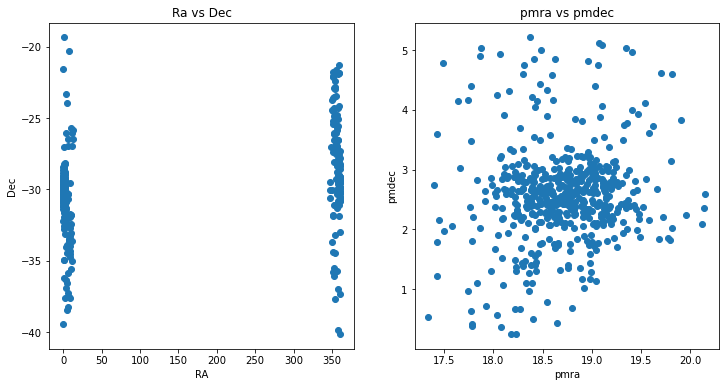

In [3]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(OC_df['RA_ICRS'],OC_df['DE_ICRS'],label='Blanco_1')
ax[1].scatter(OC_df['pmRA'],OC_df['pmDE'],label='Blanco_1')

ax[0].set_title('Ra vs Dec')
ax[1].set_title('pmra vs pmdec')

ax[0].set_xlabel('RA')
ax[0].set_ylabel('Dec')

ax[1].set_xlabel('pmra')
ax[1].set_ylabel('pmdec')

In [4]:
#getting and converting cluster members' eq coords to cartesian
blanco_1_eq_coords = SkyCoord(ra=OC_df['RA_ICRS']*u.degree, dec=OC_df['DE_ICRS']*u.degree, distance=(1000/OC_df['plx'])*u.Parcsec, frame='icrs')
blanco_1_cart_coords = blanco_1_eq_coords.cartesian.x,blanco_1_eq_coords.cartesian.y,blanco_1_eq_coords.cartesian.z


#getting and converting the center coords 
blanco_1_eq_center_coords = SkyCoord(ra=OC_tb1_df['RA_ICRS']*u.degree, dec=OC_tb1_df['DE_ICRS']*u.degree, distance=(1000/OC_tb1_df['plx'])*u.Parcsec, frame='icrs')
blanco_1_cart_center_coords = blanco_1_eq_center_coords.cartesian.x,blanco_1_eq_center_coords.cartesian.y,blanco_1_eq_center_coords.cartesian.z

#getting the distance of stars from the center of clusters
def dist(x1,y1,x2,y2):
    return ((x2-x1)**2+(y2-y1)**2)**0.5

d = dist(blanco_1_cart_center_coords[0],blanco_1_cart_center_coords[1],
         blanco_1_cart_coords[0],blanco_1_cart_coords[1])

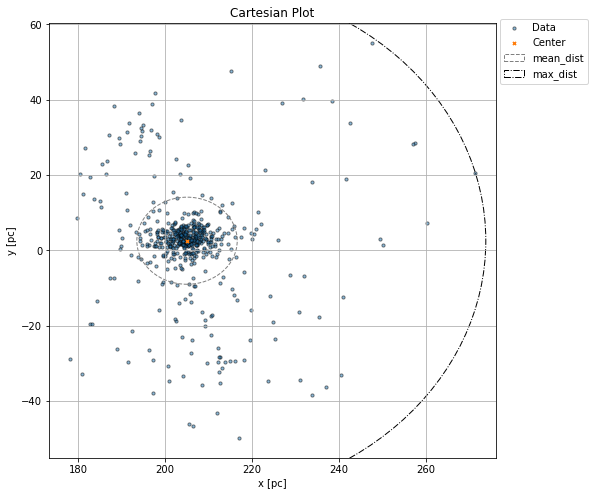

In [5]:
#plotting the cluster with radius regions
plt.figure(figsize=(8,8))
plt.scatter(blanco_1_cart_coords[0],blanco_1_cart_coords[1],label='Data',s=10,alpha=0.5,edgecolors='k')
plt.scatter(blanco_1_cart_center_coords[0],blanco_1_cart_center_coords[1],label='Center',marker='x',s=10)

ax = plt.gca()
c_max = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value),radius=np.max(d.value),
                    edgecolor='k',linestyle='-.',fill=False, label='max_dist')
c_mean = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value),radius=np.mean(d.value),
                    edgecolor='gray',linestyle='--',fill=False, label='mean_dist')
ax.add_artist(c_mean)
ax.add_artist(c_max)


plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Cartesian Plot')
plt.legend(loc=[1.01,0.86])
plt.grid()

Text(0.5, 0, 'z [pc]')

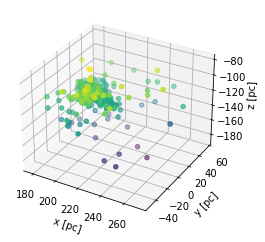

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(blanco_1_cart_coords[0], blanco_1_cart_coords[1], blanco_1_cart_coords[2], 
c=blanco_1_cart_coords[2], cmap='viridis');
ax.scatter3D(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1], blanco_1_cart_center_coords[2]);

ax.set_xlabel('x [pc]')
ax.set_ylabel('y [pc]')
ax.set_zlabel('z [pc]')

## fit different functions

In [7]:
#the profile functions

def Kings_profile(r, rho_0, r_c, r_t):
    rho_k = rho_0 * (((1 + (r / r_c) ** 2) ** -0.5 - (1 + (r_t / r_c) ** 2) ** -0.5) ** 2)
    return rho_k

def Plummers_profile(r, rho_0, a):
    rho_P = rho_0 * ((1 + ((r / a) ** 2)) ** 2)
    return rho_P

def Zhao_profile(r, rho_0, a, beta):
    rho = rho_0 * ((r / a) ** -1) * ((1 + (r / a) ** 2) ** ((1 - beta) / 2))
    return rho

## CDF

In [8]:
CDF_x = np.sort(d.value)
CDF = np.arange(1, len(d) + 1) / len(d)  #normalised CDF

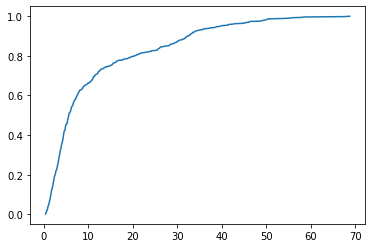

In [9]:
plt.plot(CDF_x, CDF)

## Symbolic CDF

In [12]:
rho_0, r_c, r_t, r = sympy.symbols('rho_0 r_c r_t r') 
expr=rho_0 * (((1 + (r / r_c) ** 2) ** -0.5 - (1 + (r_t / r_c) ** 2) ** -0.5) ** 2)
cdf = sympy.integrate(expr, r)

<lambdifygenerated-5>:2: RuntimeWarning: invalid value encountered in sqrt
  return rho_0*(1 + r_t**2/r_c**2)**(-1.0)*(r + r_c**2*(1 + r_t**2/r_c**2)**1.0*arctan(r/sqrt(r_c**2))/sqrt(r_c**2) - 2*sqrt(1 + r_t**2/r_c**2)*select([less(r_c**(-2.0), 0),greater(r_c**(-2.0), 0)], [sqrt(-r_c**2)*arcsin(r*sqrt(-1/r_c**2)),sqrt(r_c**2)*arcsinh(r*sqrt(r_c**(-2.0)))], default=nan))


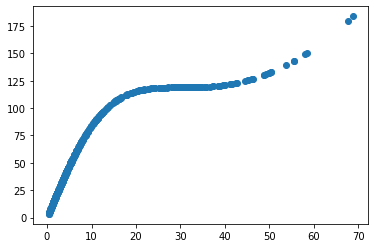

In [17]:
cdf_fun = sympy.utilities.lambdify([rho_0, r_c, r_t, r], cdf)

"""
def log_likelihood(theta, x, xerr):
    rho_0, r_c, r_t = theta
    model = cdf_fun(rho_0, r_c, r_t, x)
    
    sigma2 = xerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

"""

#plt.scatter(d, cdf_fun(50,20,30,d.value))

## compare models

## HOORAY!!!